# ¿Cuál es un mejor plan?

La empresa de telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Se realizará un análisis preliminar de los planes basado en una selección de clientes relativamente pequeña. Los datos de 500 clientes de Megaline incluyen: quiénes son los clientes, de dónde son, qué plan usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Se analizará el comportamiento de los clientes para determinar qué plan genera más ingresos.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Inicialización](#toc1_)    
- [Preparación de los datos](#toc2_)    
  - [Planes](#toc2_1_)    
  - [Usuarios](#toc2_2_)    
  - [Llamadas](#toc2_3_)    
  - [Mensajes](#toc2_4_)    
  - [Internet](#toc2_5_)    
  - [Incorporación de datos por usuario y por mes](#toc2_6_)    
- [Estudio del comportamiento del usuario](#toc3_)    
  - [Llamadas](#toc3_1_)    
  - [Mensajes](#toc3_2_)    
  - [Internet](#toc3_3_)    
  - [Ingreso](#toc3_4_)    
- [Evaluación de hipótesis estadísticas.](#toc4_)    
  - [Análisis de ingreso promedio por tipo de plan](#toc4_1_)    
  - [Análisis de ingreso promedio por región](#toc4_2_)    
- [Conclusión general](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Inicialización](#toc0_)

Se importan las librerías y se cargan los datos.

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import math as mt
import matplotlib.pyplot as plt

In [2]:
# Datos disponible para el análisis
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## <a id='toc2_'></a>[Preparación de los datos](#toc0_)

A continuación se echa un vistazo a cada una de las tablas con el objetivo de encontrar y tratar posibles errores
o valores ausentes, transformar tipos de datos y enriquecer la información de las tablas según sea necesario.

### <a id='toc2_1_'></a>[Planes](#toc0_)

In [3]:
# Información general/resumen sobre el DataFrame de los planes
print(plans.info())
plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se transforma la columna `mb_per_month_included` a gigabytes diviendo para el factor 1024 para guardar consistencia con las unidades de otras 
tablas y luego se renombra la columna.

In [4]:
# Conversión a gigabytes
plans['mb_per_month_included'] = plans['mb_per_month_included']/1024
# Se renombra la columna
plans = plans.rename(columns={'mb_per_month_included':'gb_per_month_included'})

plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


### <a id='toc2_2_'></a>[Usuarios](#toc0_)

In [5]:
# Información general/resumen sobre el DataFrame de los usuarios
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


La columna `churn_date` tiene valores ausentes, sin embargo, estos valores pueden indicar que el usuario continúa usando el servicio o plan, por lo tanto, se mantienen como están. 

Adicionalmente, se crea una nueva columna que extrae la región de la columna city, la cual servirá para el análisis posterior. 

In [6]:
users['region'] = users['city'].apply(lambda x: x.split(", ")[-1])
users['region'] = users['region'].str.replace(' MSA', '').str.strip() 
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,region
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA


### <a id='toc2_3_'></a>[Llamadas](#toc0_)

In [7]:
# Información/resumen general sobre el DataFrame de las llamadas
print(calls.info())
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Se redondea hacia arriba los valores de `duration` ya que así realiza el cobro de los minutos la compañia. 
También, se convierte la columna `call_date` a formato datetime y se crea una nueva columna que extrae el mes de la fecha de la llamada.

In [8]:

calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

calls['month'] = calls['call_date'].dt.month_name()

print(calls.info())
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 5.3+ MB
None


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,December
1,1000_145,1000,2018-12-27,14,December
2,1000_247,1000,2018-12-27,15,December
3,1000_309,1000,2018-12-28,6,December
4,1000_380,1000,2018-12-30,5,December


### <a id='toc2_4_'></a>[Mensajes](#toc0_)

In [9]:
# Información/resumen general sobre el DataFrame de los mensajes
print(messages.info())
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Se convierte la columna `message_date` a formato datetime y se crea una nueva columna que extrae el mes de la fecha del mensaje.

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

messages['month'] = messages['message_date'].dt.month_name()

print(messages.info())
messages.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB
None


,id,user_id,message_date,month
76046,1497_526,1497,2018-12-24,December
76047,1497_536,1497,2018-12-24,December
76048,1497_547,1497,2018-12-31,December
76049,1497_558,1497,2018-12-24,December
76050,1497_613,1497,2018-12-23,December


### <a id='toc2_5_'></a>[Internet](#toc0_)

In [11]:
# Información/resumen general sobre el DataFrame de los mensajes
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Se convierte la columna `mb_used` a gigabytes, se redondean los valores hacia arriba y finalmente se renombra la columna. 

In [12]:
internet['mb_used'] = internet['mb_used']/1024

# internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

internet = internet.rename(columns={'mb_used': 'gb_used'})

Adicionalmente, se convierte la columna `session_date` a formato datetime y se extrae el mes de la fecha de uso de datos.

In [13]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')


internet['month'] = internet['session_date'].dt.month_name()


print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   gb_used       104825 non-null  float64       
 4   month         104825 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.0+ MB
None


,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,December
1,1000_204,1000,2018-12-31,0.000000,December
2,1000_379,1000,2018-12-28,0.644922,December
3,1000_413,1000,2018-12-26,0.264639,December
4,1000_442,1000,2018-12-27,0.859590,December


### <a id='toc2_6_'></a>[Incorporación de datos por usuario y por mes](#toc0_)



Se calcula el total de llamadas y su duración, mensajes enviados, cantidad de datos utilizados y los ingresos mensuales por cada usuario por mes. Para analizar qué plan genera más ingresos y si los ingresos varían entre regiones, se incorpora toda la información en un solo dataframe junto con la información del plan y la región de cada usuario.

In [14]:
# Número de llamadas hechas por cada usuario por mes.
calls_by_month = calls.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
calls_by_month = calls_by_month.rename(columns={'id': 'calls_count'})
calls_by_month

,user_id,month,calls_count
0,1000,December,16
1,1001,August,27
2,1001,December,56
3,1001,November,64
4,1001,October,65
...,...,...,...
2253,1498,September,45
2254,1499,December,65
2255,1499,November,45
2256,1499,October,53


In [15]:
# Cantidad de minutos que usó cada usuario por mes. 
duration_by_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()

duration_by_month = duration_by_month.rename(columns={'duration': 'total_calls_duration'})

duration_by_month


,user_id,month,total_calls_duration
0,1000,December,124
1,1001,August,182
2,1001,December,412
3,1001,November,426
4,1001,October,393
...,...,...,...
2253,1498,September,363
2254,1499,December,496
2255,1499,November,308
2256,1499,October,385


In [16]:
# Número de mensajes enviados por cada usuario por mes
messages_by_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_by_month = messages_by_month.rename(columns={'id': 'messages_count'})
messages_by_month

,user_id,month,messages_count
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53
...,...,...,...
1801,1496,December,11
1802,1496,November,13
1803,1496,October,18
1804,1496,September,21


In [17]:
# Volumen del trafico de internet usado por cada usuario por mes.
gb_used_by_month = internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()
gb_used_by_month['gb_used'] = gb_used_by_month['gb_used'].apply(np.ceil).astype('int')
gb_used_by_month


,user_id,month,gb_used
0,1000,December,2
1,1001,August,7
2,1001,December,19
3,1001,November,19
4,1001,October,22
...,...,...,...
2272,1498,September,23
2273,1499,December,22
2274,1499,November,17
2275,1499,October,20


Se combinan a continuación todos los datos en un solo dataframe llamado `user_stats` según el user id. Sobre este se añade la información del plan y región de cada usuario. Finalmente, se realiza el tratamiento de los valores ausentes encontrados.

In [18]:
# Combinación de los datos llamadas, minutos, mensajes e internet con base en el user_id y el mes

user_stats = pd.merge(gb_used_by_month, calls_by_month, on=['user_id', 'month'], how='outer').merge(
    duration_by_month,on=['user_id', 'month'], how='outer').merge(
    messages_by_month, on=['user_id', 'month'], how='outer')
user_stats


,user_id,month,gb_used,calls_count,total_calls_duration,messages_count
0,1000,December,2.0,16.0,124.0,11.0
1,1001,August,7.0,27.0,182.0,30.0
2,1001,December,19.0,56.0,412.0,44.0
3,1001,November,19.0,64.0,426.0,36.0
4,1001,October,22.0,65.0,393.0,53.0
...,...,...,...,...,...,...
2288,1470,October,NaN,72.0,459.0,145.0
2289,1470,September,NaN,70.0,471.0,130.0
2290,1484,November,NaN,2.0,38.0,1.0
2291,1491,April,NaN,8.0,44.0,6.0


In [19]:
# Incorporación de la información del plan y region
user_info = users[['user_id', 'plan', 'region']]

user_stats = user_stats.merge(user_info, on='user_id', how='left')
user_stats['plan'] = user_stats['plan'].astype('category')

In [20]:
# Se reemplazan los valores NaN por cero asumiendo que el usuario no consumió datos, realizó llamadas o envío mensajes en determinados meses
user_stats[['gb_used','calls_count', 'total_calls_duration', 'messages_count']] = user_stats[['gb_used','calls_count', 'total_calls_duration', 'messages_count']].fillna(0)
print()
user_stats.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   user_id               2293 non-null   int64   
 1   month                 2293 non-null   object  
 2   gb_used               2293 non-null   float64 
 3   calls_count           2293 non-null   float64 
 4   total_calls_duration  2293 non-null   float64 
 5   messages_count        2293 non-null   float64 
 6   plan                  2293 non-null   category
 7   region                2293 non-null   object  
dtypes: category(1), float64(4), int64(1), object(2)
memory usage: 145.7+ KB


El paso siguiente es calcular el ingreso mensual por cada usuario. Para esto se incorpora a `user_stats` la información con las tarifas de cada plan. En base a esta información se calcula el costo total por llamadas, mensajes e internet cobrado por mes a cada usuario.

In [21]:
# Agrego la información de plans a user_stat
user_stats = pd.merge(user_stats, plans, left_on='plan', right_on='plan_name')
user_stats.head()

,user_id,month,gb_used,calls_count,total_calls_duration,messages_count,plan,region,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,December,2.0,16.0,124.0,11.0,ultimate,GA,1000,30.0,3000,70,7,0.01,0.01,ultimate
1,1006,December,32.0,9.0,59.0,139.0,ultimate,CA,1000,30.0,3000,70,7,0.01,0.01,ultimate
2,1006,November,3.0,2.0,10.0,15.0,ultimate,CA,1000,30.0,3000,70,7,0.01,0.01,ultimate
3,1008,December,15.0,85.0,634.0,26.0,ultimate,FL,1000,30.0,3000,70,7,0.01,0.01,ultimate
4,1008,November,24.0,63.0,446.0,37.0,ultimate,FL,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [22]:
# Añado el ingreso por llamadas
user_stats['monthly_cost'] =  (user_stats['total_calls_duration'] - user_stats['minutes_included']).clip(lower=0) * user_stats['usd_per_minute']
# Añado el ingreso por mensajes
user_stats['monthly_cost'] = user_stats['monthly_cost'] + (user_stats['messages_count'] - 
                              user_stats['messages_included']).clip(lower=0) * user_stats['usd_per_message']
# Añado el ingreso por datos    
user_stats['monthly_cost'] = user_stats['monthly_cost'] +  (user_stats['gb_used'] - 
                              user_stats['gb_per_month_included']).clip(lower=0) * user_stats['usd_per_gb']  

# Añado el ingreso por la tarifa mensual
user_stats['monthly_cost'] = user_stats['monthly_cost'] + user_stats['usd_monthly_pay']

# Elimino la información de las tarifas agregada previamente para acortar la tabla

user_stats = user_stats.drop(['messages_included', 'gb_per_month_included', 'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute', 'plan_name'],axis=1)
user_stats

,user_id,month,gb_used,calls_count,total_calls_duration,messages_count,plan,region,monthly_cost
0,1000,December,2.0,16.0,124.0,11.0,ultimate,GA,70.00
1,1006,December,32.0,9.0,59.0,139.0,ultimate,CA,84.00
2,1006,November,3.0,2.0,10.0,15.0,ultimate,CA,70.00
3,1008,December,15.0,85.0,634.0,26.0,ultimate,FL,70.00
4,1008,November,24.0,63.0,446.0,37.0,ultimate,FL,70.00
...,...,...,...,...,...,...,...,...,...
2288,1470,November,0.0,81.0,632.0,156.0,surf,DC-VA-MD-WV,27.14
2289,1470,October,0.0,72.0,459.0,145.0,surf,DC-VA-MD-WV,22.85
2290,1470,September,0.0,70.0,471.0,130.0,surf,DC-VA-MD-WV,22.40
2291,1484,November,0.0,2.0,38.0,1.0,surf,TX,20.00


## <a id='toc3_'></a>[Estudio del comportamiento del usuario](#toc0_)

En esta sección, se analizan promedios mensuales de minutos de llamadas, mensajes enviados y consumo de internet de cada tipo de plan. Se calculan adicionalmente estadísticas descriptivas para conocer el panorama general de las diferencias entre los planes.

Para empezar, se realiza un breve arreglo en los datos y se segmenta la información de cada plan.

In [23]:
# Se da un orden categórico a la columna month para obtener meses ordenados en las gráficas
user_stats.loc[:, 'month'] = pd.Categorical(user_stats['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

# Se crean slices de los usuarios por tipo de plan
surf_users = user_stats.query('plan == "surf"')
ultimate_users = user_stats.query('plan == "ultimate"')
print('Number of users per plan:')
print(users['plan'].value_counts())
print()
print(plans[['plan_name', 'usd_monthly_pay']])


Number of users per plan:
surf        339
ultimate    161
Name: plan, dtype: int64

  plan_name  usd_monthly_pay
0      surf               20
1  ultimate               70


Se conoce inicialmente que el plan Surf tiene más usuarios que Ultimate y que la tarifa mensual inicial es más alta para este último.

### <a id='toc3_1_'></a>[Llamadas](#toc0_)

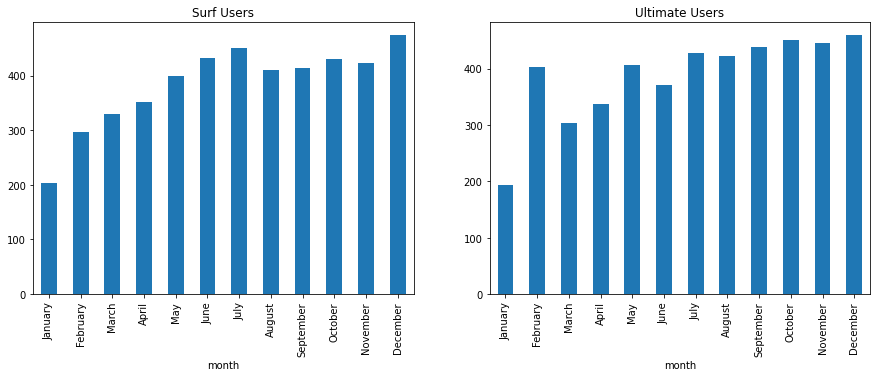

In [24]:
# gráfico de barras del promedio de minutos de llamadas por mes

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users.groupby('month')['total_calls_duration'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Surf Users')

ultimate_users.groupby('month')['total_calls_duration'].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Ultimate Users')

plt.show()


Al comparar ambas gráficas, se puede notar que el promedio de minutos de llamadas de los usuarios de Ultimate es mayor que el de los usuarios de Surf para la mayoría de los meses. Este resultado sugiere que los usuarios de Ultimate tienden a utilizar más llamadas que los usuarios de Surf.

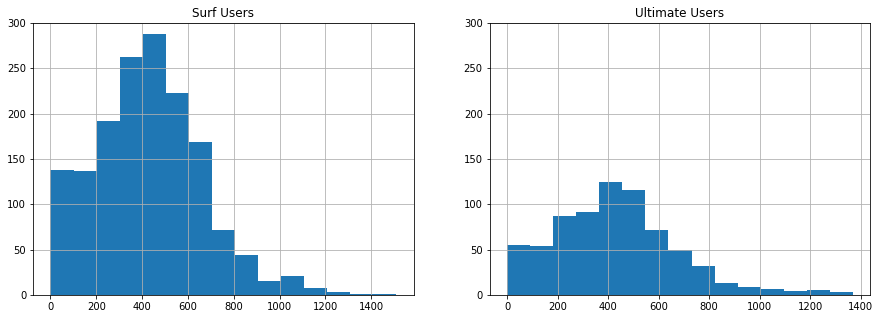

In [25]:
# Histograma de los minutos por llamada de los usuarios

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['total_calls_duration'].hist(bins=15, ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([0, 300]) 

ultimate_users['total_calls_duration'].hist(bins=15, ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([0, 300]) 

plt.show()


Comparando ambos histogramas, podemos ver que los usuarios de ambos planes tienen duración total de llamadas similar. Sin embargo, tal como se vio antes, los usuarios de Surf acumulan más minutos de llamada ya que la cantidad de usuarios es más numerosa que en el caso de Ultimate.

In [26]:
# Media y varianza de la duración mensual de llamadas.
print("Surf Users")
print(f"Varianza de duracion de llamadas: {np.var(surf_users['total_calls_duration'])}")
print(f"Media de duración de llamadas: {surf_users['total_calls_duration'].mean()}")
print()
print("Ultimate Users")
print(f"Varianza de duracion de llamadas: {np.var(ultimate_users['total_calls_duration'])}")
print(f"Media de duración de llamadas: {ultimate_users['total_calls_duration'].mean()}")

Surf Users
Varianza de duracion de llamadas: 54933.334591317485
Media de duración de llamadas: 428.7495232040687

Ultimate Users
Varianza de duracion de llamadas: 57764.12527777777
Media de duración de llamadas: 430.45


En general, estos datos sugieren que la duración de las llamadas de los usuarios de ambos planes es bastante similar, con los usuarios de Ultimate teniendo una varianza ligeramente mayor. 

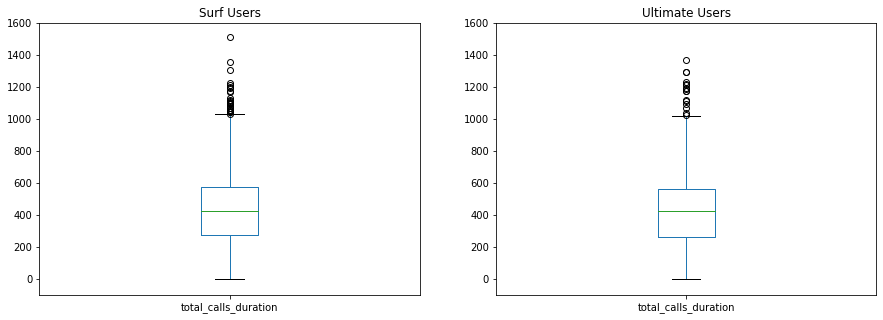

In [27]:
# Gráfico de caja de los minutos por llamada de los usuarios


fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['total_calls_duration'].plot(kind='box', ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([-100, 1600]) 

ultimate_users['total_calls_duration'].plot(kind='box', ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([-100, 1600]) 

plt.show()


In [28]:
print('Surf:')
print(surf_users['total_calls_duration'].describe())
print()
print('Ultimate:')
print(ultimate_users['total_calls_duration'].describe())

Surf:
count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: total_calls_duration, dtype: float64

Ultimate:
count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: total_calls_duration, dtype: float64


Se observa en ambos planes una distribución ligeramente sesgada a la derecha, con los percentiles 25, 50 y 75 siendo similares. También se confirma que las llamadas de los usuarios de Ultimate varían un poco más en relación a Surf.

### <a id='toc3_2_'></a>[Mensajes](#toc0_)

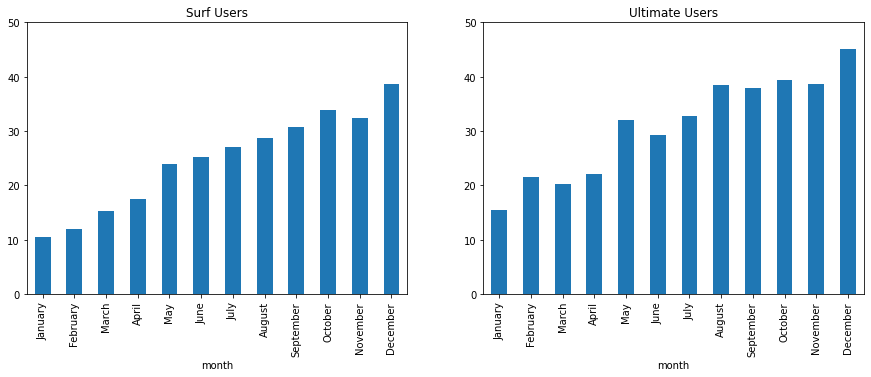

In [29]:
# gráfico de barras del promedio de mensajes enviado por los usuarios por mes
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users.groupby('month')['messages_count'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Surf Users')
axs[0].set_ylim([0, 50])

ultimate_users.groupby('month')['messages_count'].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Ultimate Users')
axs[1].set_ylim([0, 50])
plt.show()


Podemos observar lo siguiente:

- En general, los usuarios de Ultimate envían más mensajes en promedio que los usuarios de Surf cada mes.
- Ambos grupos de usuarios parecen enviar más mensajes a medida que avanza el año, con un pico en los meses de diciembre y octubre.

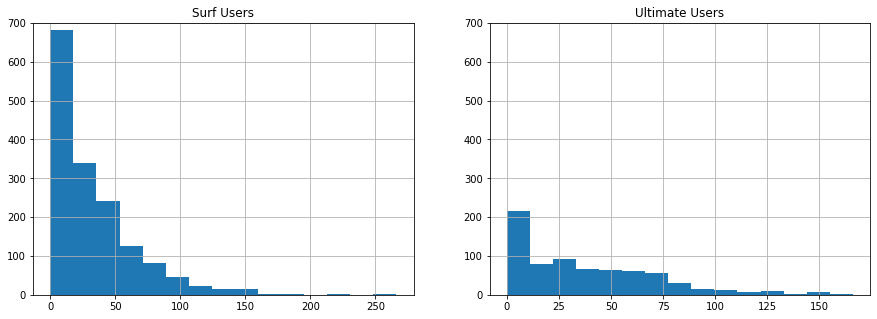

In [30]:
# histograma de la cantidad de mensajes enviados por los usuarios
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['messages_count'].hist(bins=15, ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([0, 700])

ultimate_users['messages_count'].hist(bins=15, ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([0, 700]) 

plt.show()

Para ambos grupos de usuarios, lo más común es enviar hasta cerca de 25 mensajes por mes, siendo los usuarios de Surf los que envian más mensaje. Sin embargo, al igual que las llamadas, en este resultado influye el hecho de que el plan Surf tiene más usuarios.

In [31]:
# Calcula la media y la varianza de 
print("Surf Users")
print(f"Varianza de mensajes enviados: {np.var(surf_users['messages_count'])}")
print(f"Media de mensajes enviados: {surf_users['messages_count'].mean()}")
print()
print("Ultimate Users")
print(f"Varianza de mensajes enviados: {np.var(ultimate_users['messages_count'])}")
print(f"Media de mensajes enviados: {ultimate_users['messages_count'].mean()}")

Surf Users
Varianza de mensajes enviados: 1126.008231726662
Media de mensajes enviados: 31.15956770502225

Ultimate Users
Varianza de mensajes enviados: 1207.0779147376545
Media de mensajes enviados: 37.55138888888889


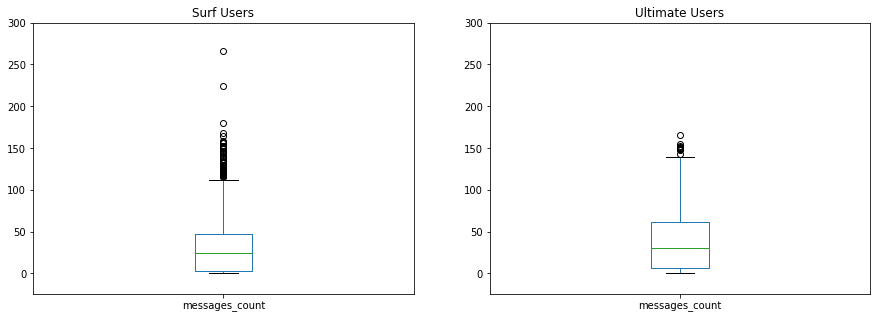

In [32]:
# gráficos de caja de la cantidad de mensajes enviados por los usuarios
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['messages_count'].plot(kind='box', ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([-25, 300]) 

ultimate_users['messages_count'].plot(kind='box', ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([-25, 300])

plt.show()


In [33]:
print('Surf:')
print(surf_users['messages_count'].describe())
print()
print('Ultimate:')
print(ultimate_users['messages_count'].describe())

Surf:
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages_count, dtype: float64

Ultimate:
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages_count, dtype: float64


Como se mencionó antes, la media del número de mensajes para los usuarios de Ultimate es mayor que la media del número de mensajes para los usuarios de Surf. Además, los valores de varianza y desviación estándar muestran una mayor variabilidad en los datos de Ultimate. En general, los usuarios de Ultimate parecen enviar más mensajes en promedio y la cantidad de mensajes que envía tiende a variar más que los usuarios de Surf.

### <a id='toc3_3_'></a>[Internet](#toc0_)

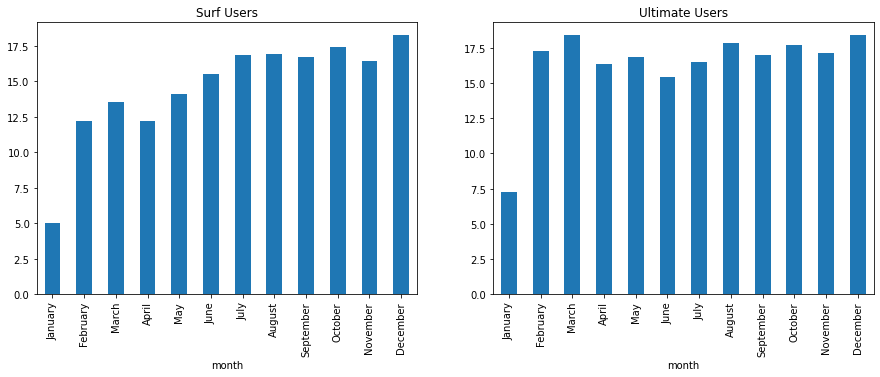

In [34]:
# gráfico de la cantidad de gb usados por los usuarios de cada plan por mes
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users.groupby('month')['gb_used'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Surf Users')

ultimate_users.groupby('month')['gb_used'].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Ultimate Users')

plt.show()


Se puede observar que en la mayoría de los meses, los usuarios de Ultimate consumen más GB en promedio que los usuarios de Surf, lo que podría indicar que estos usuarios tienen una mayor demanda de datos.

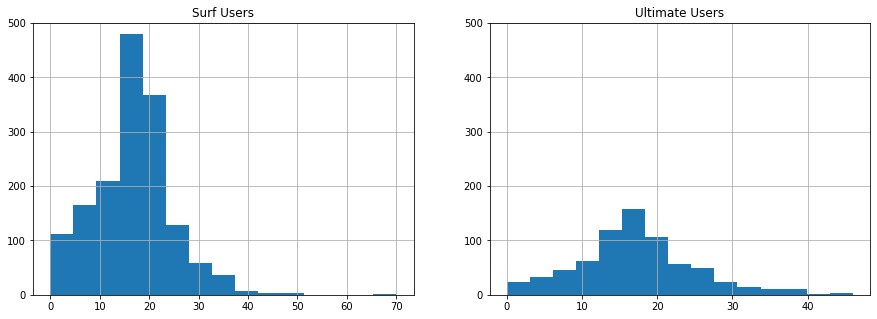

In [35]:
# gráfico de barras de la cantidad de gb usados por los usuarios
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['gb_used'].hist(bins=15, ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([0, 500]) 

ultimate_users['gb_used'].hist(bins=15, ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([0, 500]) 

plt.show()

El histograma de los usuarios de Surf muestra que la mayoría de los usuarios de este plan consumen entre 10 y 25 gigabytes por mes, con un pico en el rango de 15 a 18 gigabytes. El histograma de los usuarios de Ultimate muestra que la mayoría de los usuarios de este plan consumen entre 12 y 22 gigabytes por mes, con un pico en el rango de 26 a 28 gigabytes (límites aproximados). Nuevamente, existen frecuencias más elevadas entre los usuarios de Surf por ser un grupo más numeroso.

In [36]:
# Calcula la media y la varianza de 
print("Surf Users")
print(f"Varianza de gb usados: {np.var(surf_users['gb_used'])}")
print(f"Media degb usados: {surf_users['gb_used'].mean()}")
print()
print("Ultimate Users")
print(f"Varianza de gb usados: {np.var(ultimate_users['gb_used'])}")
print(f"Media de gb usados: {ultimate_users['gb_used'].mean()}")

Surf Users
Varianza de gb usados: 61.54444942447023
Media degb usados: 16.670692943420217

Ultimate Users
Varianza de gb usados: 58.748840663580246
Media de gb usados: 17.306944444444444


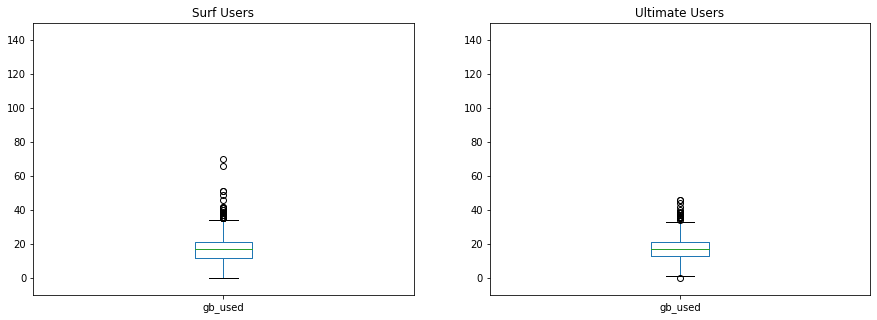

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['gb_used'].plot(kind='box', ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([-10, 150]) 

ultimate_users['gb_used'].plot(kind='box', ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([-10, 150]) 

plt.show()

In [38]:
print(surf_users['gb_used'].describe())
print()
print(ultimate_users['gb_used'].describe())

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_used, dtype: float64


La media de la cantidad de GB utilizados por mes de los usuarios de Ultimate es ligeramente mayor que la media de los usuarios de Surf. Mientras, la distribución de ambos planes es muy similar y su variación, dada por la varianza y la desviación estándar, también es muy comparable. En general, no parece haber una gran diferencia en la cantidad de GB utilizados por mes por los usuarios de ambos planes.

### <a id='toc3_4_'></a>[Ingreso](#toc0_)

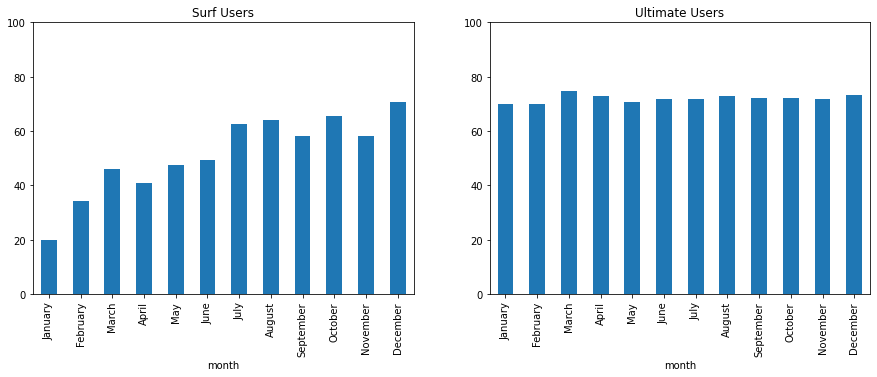

In [39]:
# gráfico de barras del ingreso promedio generado por los usuarios de cada plan por mes
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users.groupby('month')['monthly_cost'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Surf Users')
axs[0].set_ylim([0, 100])

ultimate_users.groupby('month')['monthly_cost'].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Ultimate Users')
axs[1].set_ylim([0, 100])
plt.show()

En general, los usuarios de Ultimate generan un ingreso promedio más alto y estable a lo largo del año que los usuarios de Surf. El ingreso de los usuarios de Surf se incrementa a medida que avanza el año.

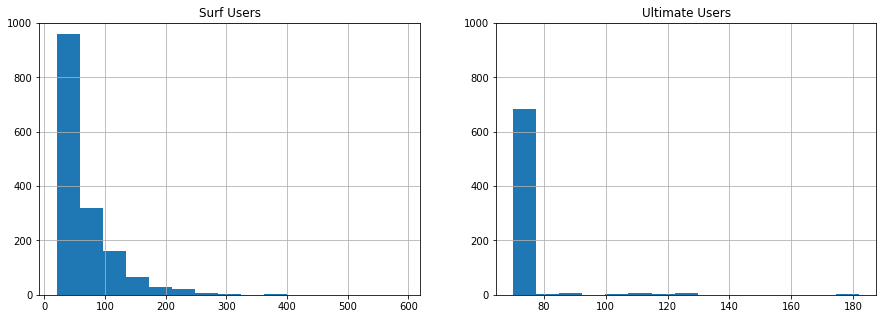

In [40]:
# histogramas del ingreso generado por los usarios de ambos planes
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['monthly_cost'].hist(bins=15, ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([0, 1000])

ultimate_users['monthly_cost'].hist(bins=15, ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([0, 1000]) 

plt.show()

En el histograma de los usuarios de Surf se puede observar que la mayoría genera entre 20 y 100 dólares al mes. Mientras que la gran mayoría de usuarios de Ultimate genera 70 dólares al mes, ya que ese es el valor correspondiente a la tarifa mensual de este plan. En general, se observa que los usuarios de Surf generan más ingresos en total por ser este un grupo más numeroso.

In [41]:
# Calcula la media y la varianza de 
print("Surf Users")
print(f"Varianza de ingresos generados: {np.var(surf_users['monthly_cost'])}")
print(f"Media de ingresos generados: {surf_users['monthly_cost'].mean()}")
print()
print("Ultimate Users")
print(f"Varianza de ingresos generadoss: {np.var(ultimate_users['monthly_cost'])}")
print(f"Media de ingresos generados: {ultimate_users['monthly_cost'].mean()}")

Surf Users
Varianza de ingresos generados: 3065.8848438690247
Media de ingresos generados: 60.706408137317226

Ultimate Users
Varianza de ingresos generadoss: 129.66814043209877
Media de ingresos generados: 72.31388888888888


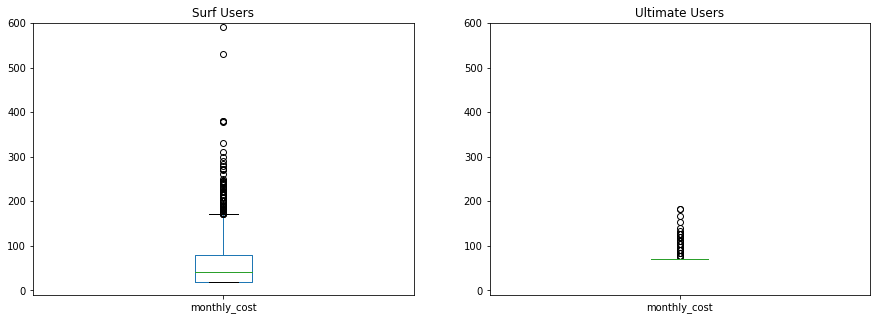

In [42]:
# gráficos de caja del consumo de gb de internet de los usarios de ambos planes
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

surf_users['monthly_cost'].plot(kind='box', ax=axs[0]).set_title('Surf Users')
axs[0].set_ylim([-10, 600]) 

ultimate_users['monthly_cost'].plot(kind='box', ax=axs[1]).set_title('Ultimate Users')
axs[1].set_ylim([-10, 600]) 

plt.show()

In [43]:
print(surf_users['monthly_cost'].describe())
print()
print(ultimate_users['monthly_cost'].describe())

count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: monthly_cost, dtype: float64

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: monthly_cost, dtype: float64


 Los datos indican que los usuarios de Ultimate generan un ingreso promedio y mediano más alto que los usuarios de Surf. Adicionalmente, el ingreso de los usuarios de Ultimate varía mucho menos, los valores generalmente se concentran en 70 dólares, ya que muy pocos usuarios superan el consumo de su paquete incluido.

## <a id='toc4_'></a>[Evaluación de hipótesis estadísticas.](#toc0_)

### <a id='toc4_1_'></a>[Análisis de ingreso promedio por tipo de plan](#toc0_)

Se desea conocer si es diferente estadísticamente el ingreso promedio de los usuarios de los planes Ultimate y Surf. Para ello, se aplica el método `scipy.stats.ttest_ind(array1, array2, equal_var)` para evaluar las siguientes hipótesis:

- **Hipótesis nula:** El ingreso promedio no difiere entre los usuarios de Surf y Ultimate. 

- **Hipótesis alternativa:** El ingreso promedio de los usuarios de Ultimate es mayor que el ingreso promedio de los usuarios de Surf.

Se aplica un nivel de significancia de alpha=0.05 para comparar con el valor p obtenido.

In [44]:
# Prueba de hipótesis
alpha  = 0.5

results = st.ttest_ind(surf_users['monthly_cost'], ultimate_users['monthly_cost'], equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


p-value: 3.17039054811355e-15
Rechazamos la hipótesis nula


El resultado indica que existe evidencia estadística para rechazar la hipótesis nula dado el valor p significativamente menor a alpha. Es decir, se puede concluir que los ingresos promedio de los usuarios de Surf y Ultimate sí son diferentes.

### <a id='toc4_2_'></a>[Análisis de ingreso promedio por región](#toc0_)

Alternativamente, se desea conocer si el ingreso promedio de los usuarios del área de  Nueva York-Nueva Jersey (NY-NJ-PA) es diferente al de los usarios del resto de regiones. Para ello, se segmenta los datos de estas áreas y se aplica nuevamente la prueba t. Las hipótesis en este caso serían:  

- **Hipótesis nula:** El ingreso promedio no difiere entre los usuarios de Nueva York-Nueva Jersey y los del resto de regiones. 

- **Hipótesis alternativa:** El ingreso promedio de los usuarios de Nueva York-Nueva Jersey es menor que el ingreso promedio de los usuarios del resto de regiones.

Se aplica nuevamente un nivel de significancia de alpha=0.05 para comparar con el valor p obtenido.

In [45]:
# Se crean slices para cada área
nymj_users = user_stats.query('region == "NY-NJ-PA"')
non_nymj_users = user_stats.query('region != "NY-NJ-PA"')


In [46]:
# Se verifica que las varianzas de ambos grupos sean diferentes
print(f"Varianza de usuarios NY-NJ: {np.var(nymj_users['monthly_cost'])}")
print(f"Varianza de resto de usuarios: {np.var(non_nymj_users['monthly_cost'])}")

# Se muestra la media del ingreso promedio de ambos grupos
print()
print(f"Media de usuarios de NY-NJ: {nymj_users['monthly_cost'].mean()}")
print(f"Media del resto de usuarios: {non_nymj_users['monthly_cost'].mean()}")

Varianza de usuarios NY-NJ: 1890.5177172681156
Varianza de resto de usuarios: 2223.8866958162175

Media de usuarios de NY-NJ: 59.921352785145885
Media del resto de usuarios: 65.22277139874738


In [47]:
# Prueba de hipótesis
alpha  = 0.5

results = st.ttest_ind(nymj_users['monthly_cost'], non_nymj_users['monthly_cost'], equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


p-value: 0.03352561588530057
Rechazamos la hipótesis nula


El resultado indica que existe evidencia estadística para rechazar la hipótesis nula dado el valor p significativamente menor a alpha. Es decir, se puede concluir que los ingresos promedio entre los usuarios de Nueva York-Nueva Jersey y los del resto de regiones sí son diferentes.

## <a id='toc5_'></a>[Conclusión general](#toc0_)

En resumen, se puede concluir que los usuarios de Ultimate y Surf tienen diferentes patrones de consumo y generación de ingreso. Los usuarios de Ultimate, aunque son menos numerosos que los usuarios de Surf, tienden en promedio a utilizar más llamadas y mensajes, y consumir más datos que los usuarios de Surf, por lo tanto, generan también más ingresos en promedio sin superar el consumo de su paquete incluido, ya que muy pocos usuarios de este plan generan ingresos mayores a la tarifa mensual de USD 70. Los usuarios de Surf, al ser un grupo más numeroso, generan más ingresos en total con más usuarios superando el consumo de su paquete incluido.


Finalmente, se encontró que los ingresos promedio de los usuarios de Surf y Ultimate son diferentes estadísticamente, así como los ingresos promedio de los usuarios de Nueva York-Nueva Jersey y el resto de regiones.